In [1]:
import numpyro
numpyro.set_host_device_count(10)

import numpy as np
import matplotlib.pyplot as plt

from h5py import File
from jax import random
import jax.numpy as jnp
from jax.scipy.stats.norm import logsf, sf

import numpyro.distributions as dist
from numpyro import deterministic, factor, plate, sample
from numpyro.infer import MCMC, NUTS, init_to_median

from corner import corner
from quadax import simpson

import candel
from candel import SPEED_OF_LIGHT

### Load the SH0ES data and the precomputed distances

In [2]:
d = candel.pvdata.load_SH0ES_separated("/Users/rstiskalek/Projects/CANDEL/data/SH0ES")
cz_host = d["czcmb_cepheid_host"]
Sigma_PV = d["PV_covmat_cepheid_host"]

fname = "/Users/rstiskalek/Projects/CANDEL/results/CH0/Cepheid_distances_mu_uniform.hdf5"
# fname = "/Users/rstiskalek/Projects/CANDEL/results/CH0/Cepheid_distances_r2_prior.hdf5"

with File(fname, "r") as f:
    mu_host = f["samples/mu_host"][...]

mu_host_mean = jnp.mean(mu_host, axis=0)
mu_host_cov = jnp.cov(mu_host, rowvar=False)

# Optionally apply some masking
m = cz_host < 3300
mu_host_mean = mu_host_mean[m]
mu_host_cov = mu_host_cov[m][:, m]
cz_host = cz_host[m]
Sigma_PV = Sigma_PV[m][:, m]

print(f"Loaded {len(mu_host_mean)} Cepheids.")


2025-07-03 16:01:27 warning: zero width found in the priors. Setting it to 1e-5.
2025-07-03 16:01:27 indices of zero width: [44]
2025-07-03 16:01:27 found zero-width prior at index 44. Setting it to 0.
Loaded 35 Cepheids.


### SH0ES model

In [ ]:
# Define a handful of useful transformations
Om = 0.315
z2distmod = candel.Redshift2Distmod(Om)
distmod2r = candel.Distmod2Distance(Om)
z2r = candel.Redshift2Distance(Om)
r2distmod_scalar = candel.Distance2Distmod(Om, is_scalar=True)
r2distmod = candel.Distance2Distmod(Om)
r2z = candel.Distance2Redshift(Om)


# NumPyro model
def model(mu_host_mean, mu_host_cov, cz_host, mu_SN_hat,
          which_selection="distance", zmax_intg=0.05, Rmax_intg=150.0):
    nhost = len(mu_host_mean)
    h = sample("h", dist.Uniform(1e-5, 1.0))

    if which_selection == "distance":
        # Sample uniformly in Mpc / h. The log PDF of the distribution is
        # always constant.
        with plate("plate_host", nhost):
            rh = sample("rh", dist.Uniform(0.0, Rmax_intg))

        r = rh / h
        mu = r2distmod(r, h)
        mu_h = mu + 5 * jnp.log10(h)
        zcosmo = r2z(r, h)

        # Sample dT in Mpc / h and then comvert to Mpc
        logdT = sample("logdT", dist.Normal(jnp.log(30), 0.4)) - jnp.log(h)
        mu_hat = deterministic("mu_hat", r2distmod_scalar(jnp.exp(logdT), h))
        mu_hat_h = mu_hat + 5 * jnp.log10(h)

        r_range = jnp.linspace(0.001, Rmax_intg, 1000)
        lp_r = 2 * jnp.log(rh) + logsf(mu_h, mu_hat_h, mu_SN_hat)
        ll_norm = jnp.log(simpson(r_range**2 * sf(r2distmod(r_range, h=1), mu_hat_h, mu_SN_hat), x=r_range, axis=-1))
        factor("ll_r", lp_r - ll_norm)
    elif which_selection == "distance_eleni":
        # Sample uniformly in redshift, the log PDF is always constant.
        with plate("plate_host", nhost):
            zcosmo = sample("zcosmo", dist.Uniform(0.0, zmax_intg))

        mu = z2distmod(zcosmo, h)
        r = z2r(zcosmo, h)

        # Similarly sample dT in Mpc / h and then convert to Mpc
        logdT = sample("logdT", dist.Normal(jnp.log(30), 0.4)) - jnp.log(h)
        mu_hat = deterministic("mu_hat", r2distmod_scalar(jnp.exp(logdT), h))

        z_range = jnp.linspace(1e-5, zmax_intg, 1000)
        lp_z = 2 * jnp.log(zcosmo) + logsf(mu, mu_hat, mu_SN_hat)
        ll_norm = jnp.log(simpson(z_range**2 * sf(z2distmod(z_range, h), mu_hat, mu_SN_hat), x=z_range, axis=-1))
        factor("ll_z", lp_z - ll_norm)
    elif which_selection == "redshift":
        # Sample uniformly in Mpc / h, again the PDF is constant.
        with plate("plate_host", nhost):
            rh = sample("rh", dist.Uniform(0.0, Rmax_intg))

        r = rh / h
        mu = r2distmod(r, h)
        zcosmo = r2z(r, h)

        rh_max = jnp.max(rh)
        factor("ll_rh", 2 * jnp.log(rh) - 3 * jnp.log(rh_max))

        alpha = 60
        factor("ll_odd", alpha * jnp.log(rh_max))
    elif which_selection == "no_selection":
        # Again sample uniformly, in Mpc. The PDF is constant.
        with plate("plate_host", nhost):
            r = sample("r", dist.Uniform(0.0, Rmax_intg))
        factor("ll_r", 2 * jnp.log(r))

        mu = r2distmod_scalar(r, h)
        zcosmo = r2z(r, h)
    elif which_selection == "no_selection_Mpch":
        # Sample uniformly but in Mpc / h. The PDF is constant.
        with plate("plate_host", nhost):
            rh = sample("r", dist.Uniform(0.0, Rmax_intg))
        factor("ll_r", 2 * jnp.log(rh))

        r = rh / h
        mu = r2distmod_scalar(r, h)
        zcosmo = r2z(r, h=h)
    else:
        raise ValueError("Invalid selection!")


    sample("mu_host", dist.MultivariateNormal(mu, mu_host_cov), obs=mu_host_mean)

    cz_pred = zcosmo * SPEED_OF_LIGHT
    sigma_v = sample("sigma_v", dist.Uniform(10, 1000))
    factor("ll_sigma_v", -jnp.log(sigma_v))

    sample("cz_host", dist.MultivariateNormal(cz_pred, Sigma_PV + sigma_v**2 * jnp.eye(nhost)), obs=cz_host)


In [4]:
def run_inference(which_selection, progress_bar=True, print_summary=True):
    num_warmup = 500
    num_steps = 1000

    if not progress_bar:
        print(f"Running `{which_selection}`")

    kernel = NUTS(model, init_strategy=init_to_median(num_samples=2500))
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_steps, num_chains=10, progress_bar=progress_bar)
    mcmc.run(
        random.PRNGKey(0),
        mu_host_mean=jnp.asarray(mu_host_mean),
        mu_host_cov=jnp.asarray(mu_host_cov),
        cz_host=jnp.asarray(cz_host),
        which_selection=which_selection,
        mu_SN_hat=0.15,
        )

    if print_summary:
        mcmc.print_summary()
    else:
        h = mcmc.get_samples()["h"]
        print(f"h = {jnp.mean(h):.3f} +/- {jnp.std(h):.3f}")

    return mcmc.get_samples()


samples_distance = run_inference("distance", progress_bar=False, print_summary=False)
# samples_distance_eleni = run_inference("distance_eleni", progress_bar=False, print_summary=False)
# samples_redshift = run_inference("redshift", progress_bar=False, print_summary=False)
samples_no_selection = run_inference("no_selection", progress_bar=False, print_summary=False)
# samples_no_selection_Mpch = run_inference("no_selection_Mpch", progress_bar=False, print_summary=False)


Running `distance`
h = 0.716 +/- 0.032
Running `no_selection`
h = 0.684 +/- 0.030


In [25]:
r2mu = candel.Distance2Distmod(Om)


mu_no_sel = r2mu(samples_no_selection["r"], samples_no_selection["h"][:, None])

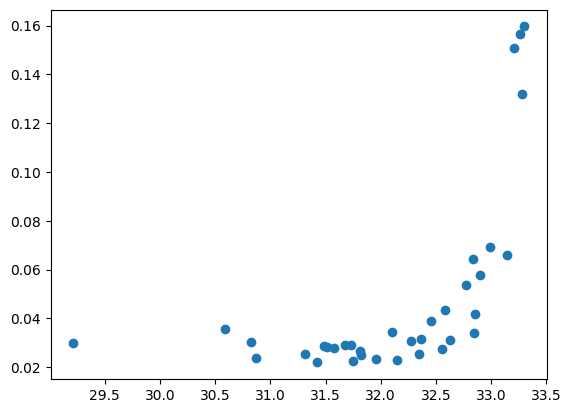

In [ ]:
r = samples_distance["rh"] / samples_distance["h"][:, None]

mu = r2mu(r, h=samples_distance["h"][:, None])


mu_mean = jnp.mean(mu, axis=0)
mu_no_sel_mean = jnp.mean(mu_no_sel, axis=0)



plt.figure()
plt.scatter(mu_no_sel_mean, mu_no_sel_mean - mu_mean, )
plt.show()


In [23]:
(mu_mean - mu_host_mean).mean()

Array(0.00408162, dtype=float32)

In [19]:
mu_host_mean

Array([29.178278, 32.921825, 32.82492 , 32.560112, 32.541218, 31.385647,
       31.289036, 31.487198, 31.447937, 32.04534 , 32.60839 , 32.46336 ,
       33.007465, 32.334915, 32.123306, 31.937994, 32.804016, 31.63116 ,
       31.730146, 31.598354, 30.843306, 30.837152, 31.812994, 32.596466,
       33.115276, 31.773083, 30.539333, 33.08772 , 32.220352, 32.37241 ,
       31.635736, 33.239677, 32.501938, 33.18479 , 32.853607],      dtype=float32)

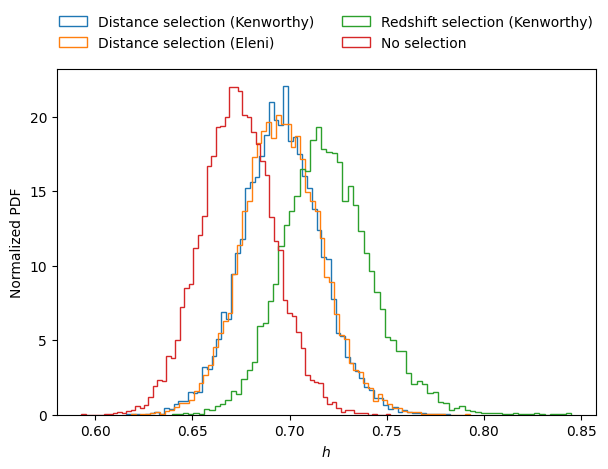

In [77]:
plt.figure()
plt.hist(samples_distance["h"], bins="auto", density=True, histtype="step", label="Distance selection (Kenworthy)")
plt.hist(samples_distance_eleni["h"], bins="auto", density=True, histtype="step", label="Distance selection (Eleni)")
plt.hist(samples_redshift["h"], bins="auto", density=True, histtype="step", label="Redshift selection (Kenworthy)")
plt.hist(samples_no_selection["h"], bins="auto", density=True, histtype="step", label="No selection")

plt.legend()
plt.xlabel(r"$h$")
plt.ylabel("Normalized PDF")

plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=2, frameon=False)

plt.tight_layout()
plt.savefig("/Users/rstiskalek/Downloads/h_comparisong.png", dpi=450)

plt.show()

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_92307/2865138398.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


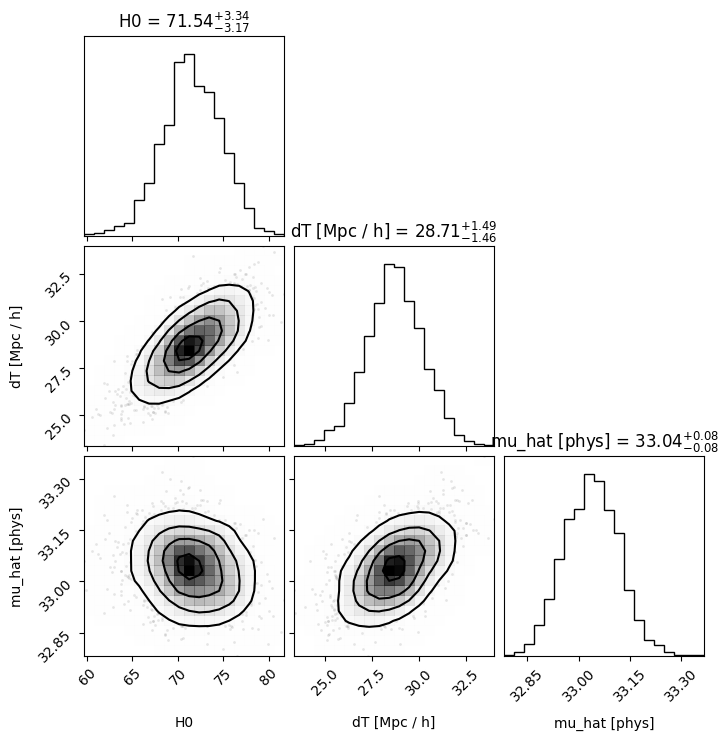

In [ ]:
samples = samples_distance

X = [samples["h"] * 100]
names = ["H0"]

if "logdT" in samples:
    X.append(jnp.exp(samples["logdT"]))
    names.append("dT [Mpc / h]")

if "mu_hat" in samples:
    X.append(samples["mu_hat"])
    names.append("mu_hat [phys]")



X = np.vstack(X).T

fig = corner(X, labels=names, show_titles=True, smooth=1)
fig.savefig("/Users/rstiskalek/Downloads/corner_dist_selection.png", dpi=450)
fig.show()